# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

# Настройка стиля
sns.set(style="whitegrid")

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
# !wget https://storage.yandexcloud.net/mle-data/ym/tracks.parquet

# !wget https://storage.yandexcloud.net/mle-data/ym/catalog_names.parquet

# !wget https://storage.yandexcloud.net/mle-data/ym/interactions.parquet

In [3]:
tracks = pd.read_parquet('tracks.parquet')
catalog_names = pd.read_parquet('catalog_names.parquet')
interactions = pd.read_parquet('interactions.parquet')

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [5]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [6]:
# Преобразуем списки в кортежи
tracks['albums'] = tracks['albums'].apply(tuple)
tracks['artists'] = tracks['artists'].apply(tuple)
tracks['genres'] = tracks['genres'].apply(tuple)

In [7]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [8]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
catalog_names.type.value_counts()

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [10]:
# catalog_names.rename(columns={'id': 'track_id'}, inplace=True)

In [11]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


Приведем все идентификаторы к строковому типу данных

In [12]:
# # Приведение типов данных
# tracks['track_id'] = tracks['track_id'].astype(str)
# catalog_names['track_id'] = catalog_names['track_id'].astype(str)
# interactions['track_id'] = interactions['track_id'].astype(str)
# interactions['user_id'] = interactions['user_id'].astype(str)

Тут падало ядро каждый раз, поэтому отказался от этой идеи.

In [13]:
# Проверка дубликатов
print(f"Дубликаты в tracks: {tracks.duplicated().sum()}")
print(f"Дубликаты в catalog_names: {catalog_names.duplicated().sum()}")
# print(f"Дубликаты в interactions: {interactions.duplicated().sum()}")

Дубликаты в tracks: 0
Дубликаты в catalog_names: 0


Тут interactions тоже проверялось через раз

In [14]:
# Проверка пустых
print(f"Пустые в tracks: {tracks.isna().sum()}")
print(f"Пустые в catalog_names: {catalog_names.isna().sum()}")

Пустые в tracks: track_id    0
albums      0
artists     0
genres      0
dtype: int64
Пустые в catalog_names: id      0
type    0
name    0
dtype: int64


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

С данными проблем нет. Все типы правильные, пропуски отсутствуют

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

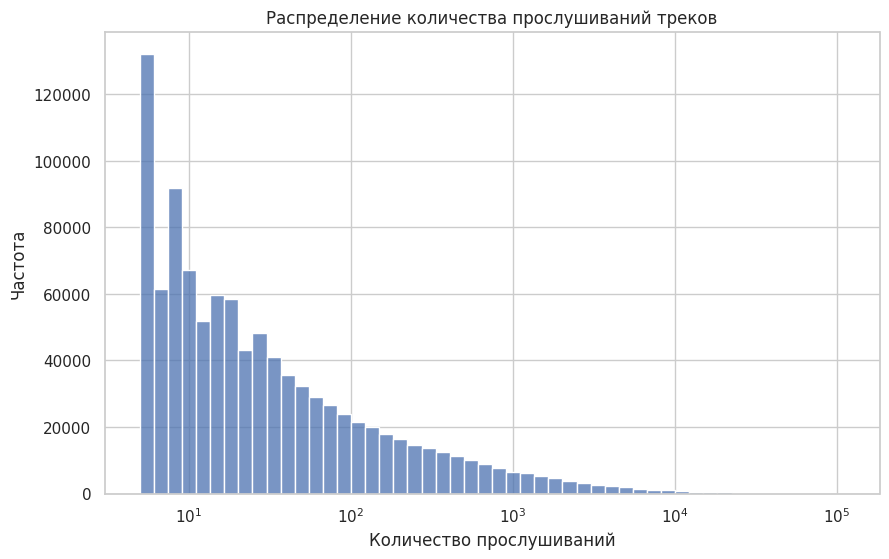

In [20]:
# Группировка по track_id для подсчета количества прослушиваний
track_listen_counts = interactions.groupby('track_id').size().reset_index(name='listen_count')

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.histplot(track_listen_counts['listen_count'], bins=50, log_scale=True)
plt.title('Распределение количества прослушиваний треков')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Частота')
plt.show()

Наиболее популярные треки

In [21]:
# Объединяем данные о треках и количестве прослушиваний
tracks_with_listen_counts = tracks.merge(
    track_listen_counts,
    left_on='track_id',
    right_on='track_id',
    how='left'
)

# Добавляем названия треков из catalog_names
tracks_with_names = tracks_with_listen_counts.merge(
    catalog_names[catalog_names['type'] == 'track'],
    left_on='track_id',
    right_on='id',
    how='left'
)

# Топ-10 самых популярных треков
top_tracks = tracks_with_names.sort_values(by='listen_count', ascending=False).head(10)
top_tracks[['track_id', 'name', 'listen_count']]

,track_id,name,listen_count
9098,53404,Smells Like Teen Spirit,111062
483876,33311009,Believer,106921
26665,178529,Numb,101924
512157,35505245,I Got Love,99490
829320,65851540,Юность,86670
368072,24692821,Way Down We Go,86246
475289,32947997,Shape of You,85886
696106,51241318,In The End,85244
90461,795836,Shape Of My Heart,85042
647237,45499814,Life,84748


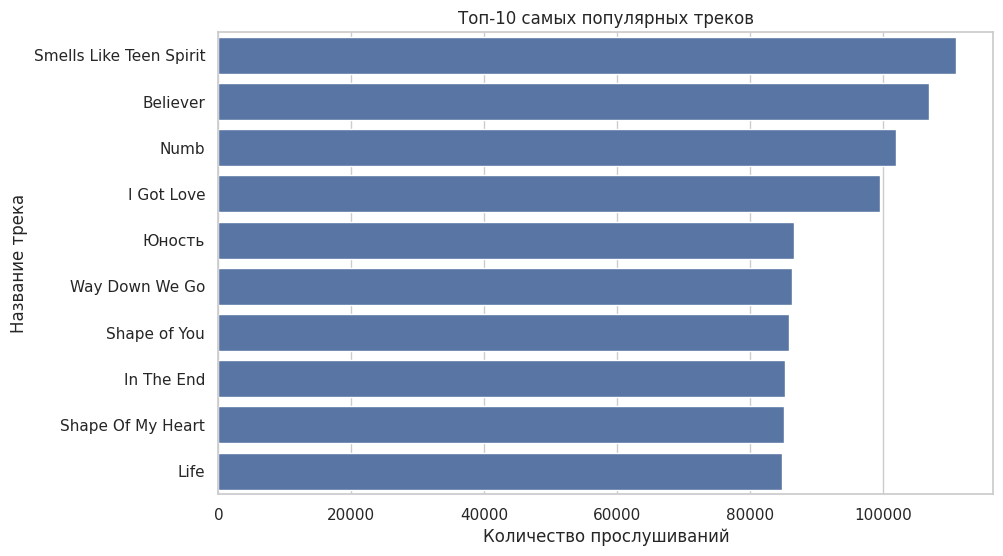

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_tracks, x='listen_count', y='name', orient='h')
plt.title('Топ-10 самых популярных треков')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Название трека')
plt.show()

Наиболее популярные жанры

In [23]:
# Разворачиваем список жанров для каждого трека
tracks_exploded = tracks.explode('genres')

# Объединяем с данными о прослушиваниях
tracks_with_genres = tracks_exploded.merge(
    track_listen_counts,
    left_on='track_id',
    right_on='track_id',
    how='left'
)

# Группируем по жанрам и суммируем количество прослушиваний
genre_popularity = tracks_with_genres.groupby('genres')['listen_count'].sum().reset_index()

# Добавляем названия жанров из catalog_names
genre_popularity_with_names = genre_popularity.merge(
    catalog_names[catalog_names['type'] == 'genre'],
    left_on='genres',
    right_on='id',
    how='left'
)

# Топ-10 самых популярных жанров
top_genres = genre_popularity_with_names.sort_values(by='listen_count', ascending=False).head(10)
top_genres[['genres', 'name', 'listen_count']]

,genres,name,listen_count
10,11,pop,55578312
70,75,rap,37799821
95,102,allrock,31092013
19,20,ruspop,26626241
2,3,rusrap,25303695
63,68,electronics,20120981
15,16,dance,16291557
1,2,rusrock,13166147
13,14,rock,12772644
42,47,metal,12437375


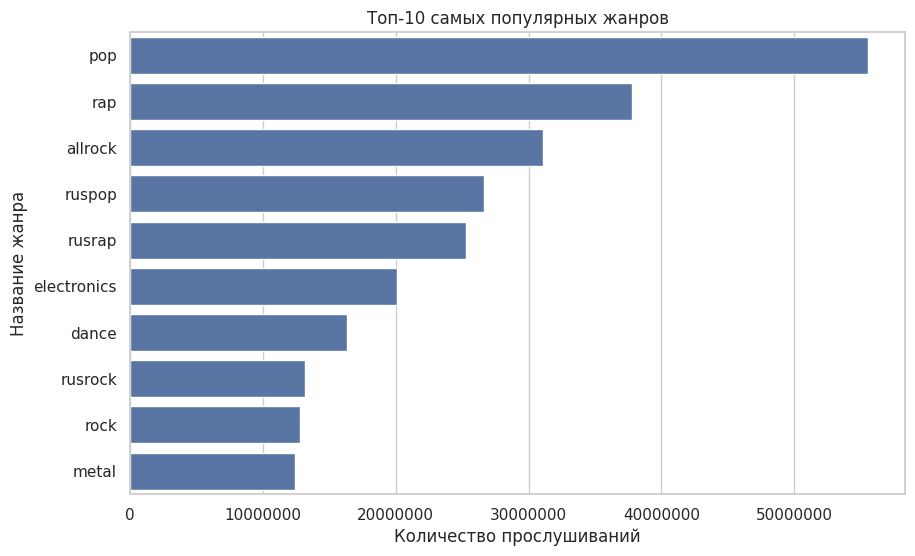

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres, x='listen_count', y='name')
plt.title('Топ-10 самых популярных жанров')
plt.xlabel('Количество прослушиваний')
plt.ylabel('Название жанра')
# Форматирование оси X
plt.ticklabel_format(style='plain', axis='x')  # Отключаем научную нотацию
plt.show()

Треки, которые никто не прослушал

In [25]:
# Треки, которые не были прослушаны
unlistened_tracks = tracks[~tracks['track_id'].isin(interactions['track_id'])]

# Добавляем названия треков из catalog_names
unlistened_tracks_with_names = unlistened_tracks.merge(
    catalog_names[catalog_names['type'] == 'track'],
    left_on='track_id',
    right_on='id',
    how='left'
)

print(f"Количество непрослушанных треков: {len(unlistened_tracks_with_names)}")

Количество непрослушанных треков: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [26]:
# Создаем словари для быстрого поиска названий
def create_name_dict(catalog, id_type):
    """
    Создает словарь для быстрого поиска названий по идентификаторам.
    
    :param catalog: DataFrame с названиями (catalog_names).
    :param id_type: Тип идентификатора ('album', 'artist', 'genre').
    :return: Словарь {id: name}.
    """
    return catalog[catalog['type'] == id_type].set_index('id')['name'].to_dict()

# Создаем словари для альбомов, исполнителей и жанров
album_name_dict = create_name_dict(catalog_names, 'album')
artist_name_dict = create_name_dict(catalog_names, 'artist')
genre_name_dict = create_name_dict(catalog_names, 'genre')

In [27]:
# Добавляем названия треков
track_name_dict = create_name_dict(catalog_names, 'track')
tracks['track_name'] = tracks['track_id'].map(track_name_dict)

In [28]:
# Добавляем названия альбомов
tracks['albums'] = tracks['albums'].apply(
    lambda x: list([album_name_dict.get(album_id, 'Unknown') for album_id in x])
)

In [29]:
# Добавляем названия исполнителей
tracks['artists'] = tracks['artists'].apply(
    lambda x: [artist_name_dict.get(artist_id, 'Unknown') for artist_id in x]
)

In [30]:
# Добавляем названия жанров
tracks['genres'] = tracks['genres'].apply(
    lambda x: [genre_name_dict.get(genre_id, 'Unknown') for genre_id in x]
)

In [31]:
tracks.head()

,track_id,albums,artists,genres,track_name
0,26,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",Complimentary Me
1,38,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",Momma's Boy
2,135,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],Atticus
3,136,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],24 Hours
4,138,"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],Don't Upset The Rhythm (Go Baby Go)


In [32]:
tracks.to_parquet('items.parquet')

In [33]:
interactions.to_parquet('events.parquet')

In [34]:
del tracks
del catalog_names
del interactions

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

Как только не пробовал загрузить всё в s3 через код, не получалось, поэтому сделал по документации yandexcloud и положил из коммандной строки:

> aws --endpoint-url https://storage.yandexcloud.net s3 cp items.parquet s3://s3-student-mle-20240920-1460ff9140/recsys/data/items.parquet
 
> aws --endpoint-url https://storage.yandexcloud.net s3 cp events.parquet s3://s3-student-mle-
20240920-1460ff9140/recsys/data/events.parquet

Уважаемый ревьюер, если подскажешь как загружать файлы через код, то буду очень благодарен.

Еще хотел бы узнать, вот я добавил в aws/config endpoint-url, но если явно не указывать флаг, то он все равно пытается подключиться к серверам amazon.

Как это пофиксить?

In [3]:
# !pip install --upgrade boto3 pyarrow

In [79]:
# !pip install boto3==1.35.93

In [78]:
# !pip install aiobotocore==2.15.2

In [74]:
items = pd.read_parquet('items.parquet')
events = pd.read_parquet('events.parquet')

In [1]:
# import s3fs
# import pandas as pd

# # Загрузка переменных окружения
# load_dotenv()

# fs = s3fs.S3FileSystem(
#     key=os.getenv("AWS_ACCESS_KEY_ID"),
#     secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
#     endpoint_url=os.getenv("AWS_ENDPOINT_URL")
# )

# # Запись данных
# with fs.open(f"s3://{os.getenv('S3_BUCKET_NAME')}/recsys/data/items.parquet", 'wb') as f:
#     items.to_parquet(f, engine="pyarrow")

# with fs.open(f"s3://{os.getenv('S3_BUCKET_NAME')}/recsys/data/events.parquet", 'wb') as f:
#     events.to_parquet(f, engine="pyarrow")

In [2]:
# import os
# import boto3

# load_dotenv()

# S3_BUCKET = os.getenv("S3_BUCKET_NAME")
# STORAGE_OPTIONS={
#     "endpoint_url": os.getenv("AWS_ENDPOINT_URL"), 
#     "key": os.getenv("AWS_ACCESS_KEY_ID"), 
#     "secret": os.getenv("AWS_SECRET_ACCESS_KEY"),
#     "client_kwargs":{"region_name": os.getenv("AWS_REGION")},
#     "config_kwargs": {"signature_version": "s3v4"}
# }

# items.to_parquet(
#     f"s3://{S3_BUCKET}/recsys/data/items.parquet", 
#     engine="pyarrow", storage_options=STORAGE_OPTIONS
# )
# events.to_parquet(
#     f"s3://{S3_BUCKET}/recsys/data/events.parquet",
#     engine="pyarrow", storage_options=STORAGE_OPTIONS
# )

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.